# Homework 3

In [1]:
import rpy2
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
np.random.seed(1337)
%load_ext rpy2.ipython

In [2]:
%%R -o data
# Make sure we have correct R library path
.libPaths("C:/Users/ville_000/Documents/R/win-library/3.6")
library(rethinking)
library(dagitty)
data(foxes)
data = foxes

D:\condaenvs\dev\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


## Overal info

All three problems below are based on the same data. The data in data(foxes) are 116 foxes from 30 different urban groups in England. These foxes are like
 street gangs. Group size varies from 2 to 8 individuals. Each group maintains its own (almost exclusive) urban territory. Some territories are larger than others. The area variable encodes this information. Some territories also have more avgfood than others. We want to model the weight of each fox. For the problems below, assume this DAG:

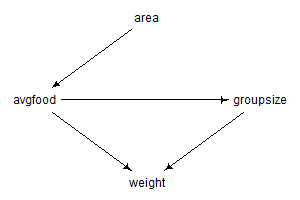

In [13]:
%%R -w 300 -h 200 -u px
mydag = dagitty("dag{
    area -> avgfood
    avgfood -> groupsize
    avgfood -> weight
    groupsize -> weight
}")
coordinates(mydag) = list(x=c(area=2, avgfood=1, groupsize=3, weight=2),
                          y=c(area=0, avgfood=1, groupsize=1, weight=2))
drawdag(mydag)

## Dataset EDA

In [35]:
data.head(5)

,group,avgfood,groupsize,area,weight,avgfood_s
0,1,0.37,2,1.09,5.02,-1.93
1,1,0.37,2,1.09,2.84,-1.93
2,2,0.53,2,2.05,5.33,-1.12
3,2,0.53,2,2.05,6.07,-1.12
4,3,0.49,2,2.12,5.85,-1.33


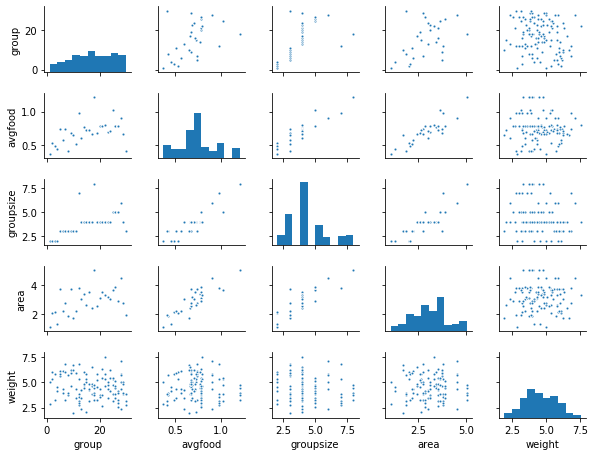

In [25]:
_ = sns.pairplot(data, diag_kind = 'hist', height=1.3, aspect=1.3, plot_kws={"s": 8})

## Question 1

*Use a model to infer the total causal influence of area on weight. Would increasing the area available to each fox make it heavier (healthier)? You might want to standardize the variables. Regardless, use prior predictive simulation to show that your model’s prior predictions stay within the possible outcome range.*

First define

\begin{align}
W &: \text{weight} \\
A &: \text{area} (standardized) \\
F &: \text{avgfood (standardized)} \\
G &: \text{groupsize}
\end{align}

*"Standardized"* means standardizing the variable in the regression by taking a z-score. 

Let's try following OLS linear regression model.

$$W = \alpha + \beta_1 A + \beta_2 F + \beta_3 G + \epsilon \ ,$$

where $\epsilon \sim N(0,\sigma)$. In the language of the course we rewrite above and add priors:

\begin{align}
W \sim N(\mu_W \sigma) \qquad & \text{likelihood} \\
\mu_W = \alpha_{G[i]} + \beta_1 A + \beta_2 F \qquad & \text{linear model}  \\
\alpha_{G[i]} \sim x \ \text{for } i=1, \dots  \qquad & \text{prior}  \\
\beta_1 \sim x \qquad & \text{prior} \\
\beta_2 \sim x \qquad & \text{prior} \\
\sigma \sim x \qquad & \text{prior}  \\
\end{align}

Note that we treat $G$ as a categorical indicator *variable*, leading to multiple intercept parameters $\alpha_{G[i]}$. It is integer-encoded, not dummy encoded. This is how it was instructed in the book and lessons. However, I do not understand how *quap* handles this under the hood; how come would there not be ordinality involved with integer-encoded variable? How do we fit two separate intercepts?? 

In [39]:
data['area_s'] = StandardScaler().fit_transform(data[['area']].values)
data['avgfood_s'] = StandardScaler().fit_transform(data[['avgfood']].values)
data.head(1)

,group,avgfood,groupsize,area,weight,avgfood_s,area_s
0,1,0.37,2,1.09,5.02,-1.93,-2.25


In [41]:
%%R -i data
m1 = quap(
    alist(
        weight ~ dnorm(mu_W, sigma),
        mu_W <- a[group] + b1*area_s + b2*avgfood_s,
        a[group] ~  dnorm(0, 1),
        b1 ~  dnorm(0, 1),
        b2 ~  dnorm(0, 1),
        sigma ~ dunif(0,50)
    ),
    data=data
)

D:\condaenvs\dev\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
